In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
data_folder = "/home/wenceslai/Documents/kaggle_housing_prices"
train_data = pd.read_csv(os.path.join(data_folder, 'train.csv'))

In [191]:
total = train_data.isnull().sum().sort_values(ascending=False)
percent = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


0     2003.0
1     1976.0
2     2001.0
3     1998.0
4     2000.0
5     1993.0
6     2004.0
7     1973.0
8     1931.0
9     1939.0
10    1965.0
11    2005.0
12    1962.0
13    2006.0
14    1960.0
15    1991.0
16    1970.0
17    1967.0
18    2004.0
19    1958.0
20    2005.0
21    1930.0
Name: GarageYrBlt, dtype: float64


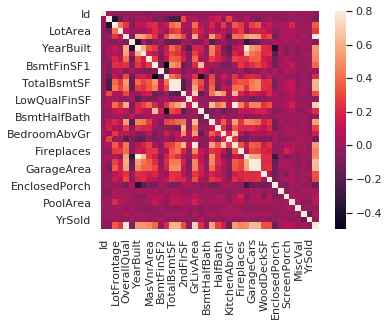

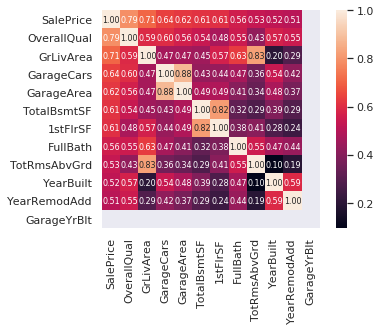

In [192]:
train_data['GarageYrBlt'] = train_data['GarageYrBlt'].astype(float)
print(train_data['GarageYrBlt'][0:22])
corrmat = train_data.corr()
sns.heatmap(corrmat, vmax=0.8, square=True)
plt.show()
var = 'SalePrice'
k = 12
cols = corrmat.nlargest(k, var)[var].index #most correlating with var
cm = np.corrcoef(train_data[cols].values.T)
sns.set(font_scale=1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':8},
                 yticklabels=cols.values, xticklabels=cols.values)

In [193]:
chosen_columns = ['SalePrice', 'OverallQual', 'GrLivArea',
                  'GarageCars', 'TotalBsmtSF', 'FullBath',
                  'YearBuilt', '1stFlrSF']
#plt.show()
#sns.pairplot(train_data[chosen_columns], size=2.5)
train_data = train_data[chosen_columns]

y = train_data['SalePrice']
y = y.values
y = y.reshape(len(y), 1)

X = train_data.drop(['SalePrice'], axis=1)
X = X.values

val_size = 1

X_train = X[:-val_size]
y_train = y[:-val_size]
X_val = X[-val_size:]
y_val = y[-val_size:]

In [194]:
def normalize(X):
    X = X.astype('float64')
    mean = X.mean(axis=0)
    X -= mean
    std = X.std(axis=0)
    X /= std
    return mean, std, X

#normalize test/val data with train_mean/std
y_mean, y_std, y_train = normalize(y_train)
X_mean, X_std, X_train = normalize(X_train)

y_val = y_val.astype('float64'); y_val -= y_mean; y_val /= y_std
X_val = X_val.astype('float64'); X_val -= X_mean; X_val /= X_std

In [195]:
n = X_train.shape[-1]
m = X_train.shape[0]

X_train = np.hstack((np.ones((m, 1)), X_train))
X_val = np.hstack((np.ones((val_size, 1)), X_val))
theta = np.random.randn(n + 1, 1)

def step(X, y, theta, lamb=0):
    m = len(X)
    theta_grad = np.zeros(theta.shape)

    theta_grad[0] = (1 / m) * np.matmul(X[:, 0].T, np.matmul(X, theta) - y)
    theta_grad[1:] = (1 / m) * np.matmul(X[:, 1:].T, np.matmul(X, theta) - y) + lamb / m * theta[1:]

    J = (1 / (2 * m)) * np.sum((np.matmul(X, theta) - y)**2) + lamb / (2 * m) * sum(theta[1:]**2)
    return J, theta_grad


epochs = 300
lr = 0.08

In [196]:
#lambdas = [0, 0.1, 0.03, 0.9, 1,5, 4, 8, 12, 20, 140, 400, 388, 350, 200]
#top_score = 10000
#for l in lambdas:
for epoch in range(epochs):
        C = np.concatenate((X_train, y_train), axis=1)
        np.random.shuffle(C)
        X_train = C[:, :-1]
        y_train = C[:, -1].reshape((y_train.shape[0], 1))

        J, theta_grad = step(X_train, y_train, theta, lamb=350)
        theta -= lr * theta_grad

        J_val = (1 / (2 * val_size)) * np.sum((np.matmul(X_val, theta) - y_val)**2)
        if epoch % 10 == 0 or epoch == epochs - 1: print(f"epoch: {epoch} trainJ: {J} valJ: {J_val}\n")
    #if top_score > J_val:
        #top_score = J_val
        #top_l = l
#print(top_score, top_l)

epoch: 0 trainJ: [3.51931282] valJ: 2.7995349824857083

epoch: 10 trainJ: [0.93587065] valJ: 0.34178338806148406

epoch: 20 trainJ: [0.38269309] valJ: 0.04920957253178715

epoch: 30 trainJ: [0.22831368] valJ: 0.007475026679912208

epoch: 40 trainJ: [0.17733466] valJ: 0.0015766490742657488

epoch: 50 trainJ: [0.15821229] valJ: 0.0007318851919334199

epoch: 60 trainJ: [0.15041965] valJ: 0.0007147128784479394

epoch: 70 trainJ: [0.14707854] valJ: 0.0009121072101749582

epoch: 80 trainJ: [0.14559982] valJ: 0.001172861516377387

epoch: 90 trainJ: [0.14493142] valJ: 0.0014287720056999555

epoch: 100 trainJ: [0.14462476] valJ: 0.001649106557085114

epoch: 110 trainJ: [0.14448251] valJ: 0.001825249653792535

epoch: 120 trainJ: [0.14441596] valJ: 0.0019597653076763163

epoch: 130 trainJ: [0.14438462] valJ: 0.002059508601352516

epoch: 140 trainJ: [0.14436979] valJ: 0.0021320410673171856

epoch: 150 trainJ: [0.14436274] valJ: 0.002184097748229726

epoch: 160 trainJ: [0.14435938] valJ: 0.00222112

In [197]:
"""
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
y_preds = model.predict(X_val)
acc = mean_squared_error(y_preds, y_val)
print(acc)
"""

'\nfrom sklearn.linear_model import LinearRegression\nmodel = LinearRegression()\n\nmodel.fit(X_train, y_train)\n\nfrom sklearn.metrics import mean_squared_error\ny_preds = model.predict(X_val)\nacc = mean_squared_error(y_preds, y_val)\nprint(acc)\n'

In [198]:
test_data = pd.read_csv(os.path.join(data_folder, 'test.csv'))

test_chosen_columns = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', '1stFlrSF']
test_data = test_data[test_chosen_columns]

#test_data = handle_non_numeric(test_data)
test_data = test_data.fillna(test_data.mean())
#test_data.dropna(axis=0)
print(test_data.head)

X_test = test_data.values
X_test = X_test.astype('float64'); X_test -= X_mean; X_test /= X_std

#print(theta.shape)
#print(X_test.shape)

X_test = np.hstack((np.ones((len(X_test), 1)), X_test))
predictions = np.matmul(X_test, theta)

#predictions = model.predict(X_test)
predictions *= y_std; predictions += y_mean

submission = np.empty((len(X_test), 2))

id_index = 1461
for i in range(len(X_test)):
    submission[i, 0] = id_index
    submission[i, 1] = predictions[i]
    id_index += 1

submission_final = pd.DataFrame({'Id' : submission[:, 0], 'SalePrice' : submission[:, 1]})
submission_final['Id'] = submission_final['Id'].astype(int)
submission_final.to_csv(os.path.join(data_folder, 'submission_out3.csv'), index=False)

<bound method NDFrame.head of       OverallQual  GrLivArea  GarageCars  TotalBsmtSF  FullBath  YearBuilt  \
0               5        896         1.0        882.0         1       1961   
1               6       1329         1.0       1329.0         1       1958   
2               5       1629         2.0        928.0         2       1997   
3               6       1604         2.0        926.0         2       1998   
4               8       1280         2.0       1280.0         2       1992   
...           ...        ...         ...          ...       ...        ...   
1454            4       1092         0.0        546.0         1       1970   
1455            4       1092         1.0        546.0         1       1970   
1456            5       1224         2.0       1224.0         1       1960   
1457            5        970         0.0        912.0         1       1992   
1458            7       2000         3.0        996.0         2       1993   

      1stFlrSF  
0          896  